# Address completeness classification with machine learning techniques
Data & AI course, UC Leuven, 2021 Fall
### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal if the assignment to implement a address classification into complete/incomplete by incorporating machine learning techniques. The workload can be split into three steps:
- extracting data from addresses, that could be used to train an AI model
- training an AI model(s)
- Evaluate the performance and applicability of model(s)

## Preparing training data
Before preparing test data, utility functions for reading/writing excel files are needed:

In [18]:
import pandas as pd

def read_DataFrame_from_file(filename: str, numberOfRows: int = None):
    return pd.read_excel(filename, nrows = numberOfRows, keep_default_na=False)


def write_DataFrame_to_excel(df: pd.DataFrame, filename: str):
    sheet_name = 'Output'

    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

        worksheet = writer.sheets[sheet_name]
        # format all data as a table
        worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
            'columns': [{'header': col_name} for col_name in df.columns],
            'style': 'Table Style Medium 5'
        })
        # Widen the address column
        worksheet.set_column('A:A', 70)

Then, it is possible to extract the following data from each address entry:

Number of characters

In [19]:
def getAddressLength(address: str):
    return len(address)
print(getAddressLength('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

48


Number of digits

In [20]:
import re

def getDigitsCount(address: str):
    return len(re.findall(r'\d', address))
print(getDigitsCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

12


Number of groups of consecutive digits

In [21]:
def getDigitGroupCount(address: str):
    return len(re.findall(r'(\d+)', address))
print(getDigitGroupCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

3


Number of separated digit groups, examples: 1-123, 124 565, 12/27

In [22]:
def getSeparatedDigitGroupCount(address: str):
    return len(re.findall(r'(\d+)[^\d,](\d+)', address))
print(getSeparatedDigitGroupCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

1


Number of space or comma separated tokens

In [23]:
def getTokenCount(address: str):
    return len(re.findall(r'([^\s,]+)', address))
print(getTokenCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

7


Comma count

In [24]:
def getCommaCount(address: str):
    return len(re.findall(r',', address))
print(getCommaCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

2


Number of comma separated substrings, containing a number

In [25]:
def getCommaSeparatedEntityWithNumbersCount(address: str):
    return len(re.findall(r'[^,]*\d+[^,]*', address))
print(getCommaSeparatedEntityWithNumbersCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

2


The number of comma separated entities, having a number and a separated word

In [26]:
def getCommaSeparatedEntityWithNumbersNearWordsCount(address: str):
    return len(re.findall(r'([a-zA-Z]{3,})\s(\w+-)?\d+(-\w+)?|(\w+-)?\d+(-\w+)?\s([a-zA-Z]{3,})[^,]*', address))
print(getCommaSeparatedEntityWithNumbersNearWordsCount('8200 116 Avenue S.E.,NewCastle, Washington 98056, NO-420'))

2


### Complete code for preparing the training data

In [27]:
DATA_INPUT_FILENAME = 'raw_data.xlsx'
DATA_OUTPUT_FILENAME = 'training_data.xlsx'
NUMBER_OF_PARSABLE_RECORDS = 999

PROPERTY_LABEL = 'label'
PROPERTY_ADDRESS = 'address'

PROPERTY_LENGTH = 'length'
PROPERTY_DIGITS_COUNT = 'digit_count'
PROPERTY_DIGITS_GROUP_COUNT = 'digits_group_count'
PROPERTY_SEPARATED_DIGIT_GROUP_COUNT = 'separated_digits_group_count'
PROPERTY_TOKEN_COUNT = 'token_count'
PROPERTY_COMMA_COUNT = 'comma_count'
PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS = 'comma_separated_entities_having_numbers'
PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS = 'comma_separated_entities_having_numbers_near_words'

def assignProperty(dataFrame: pd.DataFrame, property: str, fun: callable):
    dataFrame[property] = dataFrame.apply(lambda row: fun(row[PROPERTY_ADDRESS]), axis=1)


def enrichDataFrameWithProperties(frame: pd.DataFrame):
    assignProperty(frame, PROPERTY_LENGTH, getAddressLength)
    assignProperty(frame, PROPERTY_DIGITS_COUNT, getDigitsCount)
    assignProperty(frame, PROPERTY_DIGITS_GROUP_COUNT, getDigitGroupCount)
    assignProperty(frame, PROPERTY_SEPARATED_DIGIT_GROUP_COUNT, getSeparatedDigitGroupCount)
    assignProperty(frame, PROPERTY_TOKEN_COUNT, getTokenCount)
    assignProperty(frame, PROPERTY_COMMA_COUNT, getCommaCount)
    assignProperty(frame, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS, getCommaSeparatedEntityWithNumbersCount)
    assignProperty(frame, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS, getCommaSeparatedEntityWithNumbersNearWordsCount)


rawData = read_DataFrame_from_file(DATA_INPUT_FILENAME, NUMBER_OF_PARSABLE_RECORDS)

parsedData = pd.DataFrame()
parsedData[PROPERTY_ADDRESS] = rawData['person_address']
enrichDataFrameWithProperties(parsedData)
parsedData[PROPERTY_LABEL] = rawData['label']

write_DataFrame_to_excel(parsedData, DATA_OUTPUT_FILENAME)

An example of prepared training data:
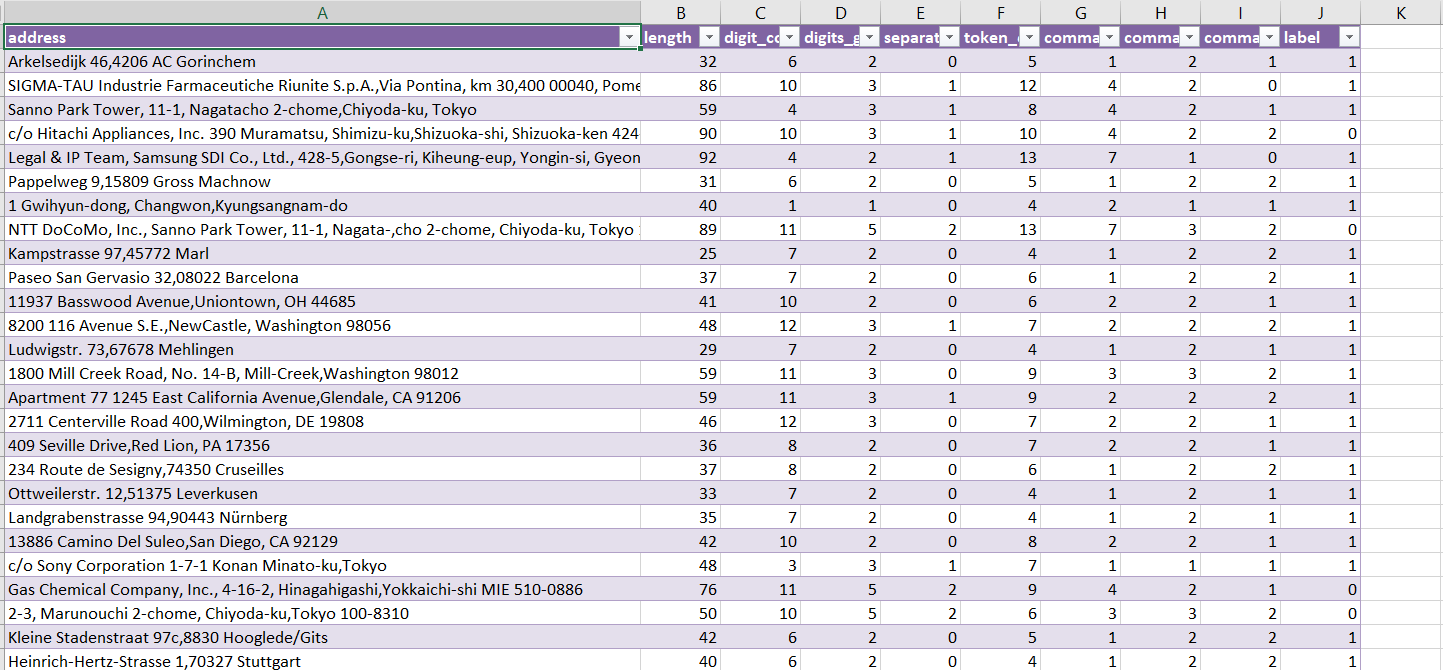

# Data analysis

# Utility functions
### Calculating Precision, Recall, F1 score
The following function can be used to callculate the precision, recall and F1 score of prediction results:

In [28]:
def get_precision_recall_f1(actual: list, predicted: list):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    wrong = 0

    for index, predictedVal in enumerate(predicted):
        actualVal = actual[index]
        if (actualVal and actualVal == predictedVal):
            true_positives += 1
        elif (predictedVal and actualVal != predictedVal):
            false_positives += 1
        elif (actualVal and actualVal != predictedVal):
            false_negatives += 1
    
    precision = true_positives / max(true_positives + false_positives, 1)
    recall = true_positives / max(true_positives + false_negatives, 1)
    f1 = 2 * ((precision * recall) / (1 if precision + recall == 0 else precision + recall))
        
    return [el * 100 for el in [precision, recall, f1]]

[precision, recall, f1] = get_precision_recall_f1([0,1,1,1,0], [1,1,0,0,0])

print('Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'.format(precision, recall, f1))

Precision: 50.00 | Recall: 33.33 | F1: 40.00


# Random Forest model
First the training data is read from a file, label values are saved in a `numpy` array, then address and label fields are removed from the dataframe. Features are also converted into an array, their names are also preserved for a future reference.

Finally, features and labels are split into training and test sets in a ratio of `4:1`. A constant random state is used to ensure that the same results are produced each time the algorithm is run.

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 420
TRAINING_DATA_FILENAME = 'training_data.xlsx'

dataFrame: pd.DataFrame = read_DataFrame_from_file(TRAINING_DATA_FILENAME)
labels = np.array(dataFrame[PROPERTY_LABEL])

featureFrame = dataFrame.drop([PROPERTY_LABEL, PROPERTY_ADDRESS], axis = 1)
feature_list = list(featureFrame.columns)
features = np.array(featureFrame)

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.2, random_state = RANDOM_STATE
)

Then, a `RandomForestClassifier` model is trained by using `1000` estimators and predefined random state:

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000, random_state = RANDOM_STATE)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=420)

We can now check how well the model performs when classifying training and test data:

In [31]:
train_predictions = rf.predict(train_features)
train_accuracy = rf.score(train_features, train_labels) * 100.0
[train_precision, train_recall, train_f1] = get_precision_recall_f1(train_labels, train_predictions)

test_predictions = rf.predict(test_features)
test_accuracy = rf.score(test_features, test_labels) * 100.0
[test_precision, test_recall, test_f1] = get_precision_recall_f1(test_labels, test_predictions)

print('For training data:')
print('Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'
      .format(train_accuracy, train_precision, train_recall, train_f1))
print('For test data:')
print('Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'
      .format(test_accuracy, test_precision, test_recall, test_f1))

For training data:
Accuracy: 99.87 | Precision: 99.73 | Recall: 100.00 | F1: 99.87
For test data:
Accuracy: 95.50 | Precision: 93.14 | Recall: 97.94 | F1: 95.48


We can also check how important each feature is in determining the completeness of an address:

In [32]:
importances = list(rf.feature_importances_)
feature_importances = [
    (feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)
]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for pair in feature_importances:
    print('Variable: {:50} Importance: {}'.format(*pair))

Variable: length                                             Importance: 0.22
Variable: digit_count                                        Importance: 0.18
Variable: token_count                                        Importance: 0.18
Variable: digits_group_count                                 Importance: 0.17
Variable: comma_separated_entities_having_numbers            Importance: 0.14
Variable: comma_separated_entities_having_numbers_near_words Importance: 0.06
Variable: comma_count                                        Importance: 0.04
Variable: separated_digits_group_count                       Importance: 0.01


It can be concluded that the most import criteria in determining whether an address is complete or not (in a trained random forest) are length, digit, token and digit group count. Least important features, on the other hand, are comma count and separated digit groups count.

Actually, dropping the separated digit group count property from the model slightly increases both it's precision and recall on test data, so this feature is not only not needed, but also detrimental to model's performance.

In [33]:
featureFrame = dataFrame.drop([PROPERTY_LABEL, PROPERTY_ADDRESS, PROPERTY_SEPARATED_DIGIT_GROUP_COUNT], axis = 1)
feature_list = list(featureFrame.columns)
features = np.array(featureFrame)

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.2, random_state = RANDOM_STATE
)

rf = RandomForestClassifier(n_estimators = 1000, random_state = RANDOM_STATE)
rf.fit(train_features, train_labels)

train_predictions = rf.predict(train_features)
train_accuracy = rf.score(train_features, train_labels) * 100.0
[train_precision, train_recall, train_f1] = get_precision_recall_f1(train_labels, train_predictions)

test_predictions = rf.predict(test_features)
test_accuracy = rf.score(test_features, test_labels) * 100.0
[test_precision, test_recall, test_f1] = get_precision_recall_f1(test_labels, test_predictions)

print('For training data:')
print('Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'
      .format(train_accuracy, train_precision, train_recall, train_f1))
print('For test data:')
print('Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'
      .format(test_accuracy, test_precision, test_recall, test_f1))

For training data:
Accuracy: 99.87 | Precision: 99.73 | Recall: 100.00 | F1: 99.87
For test data:
Accuracy: 96.00 | Precision: 93.20 | Recall: 98.97 | F1: 96.00


In [34]:
from sklearn.tree import export_graphviz
import pydot

tree = rf.estimators_[10]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

ModuleNotFoundError: No module named 'pydot'

We can see that the generated tree model has a depth of 16 levels.

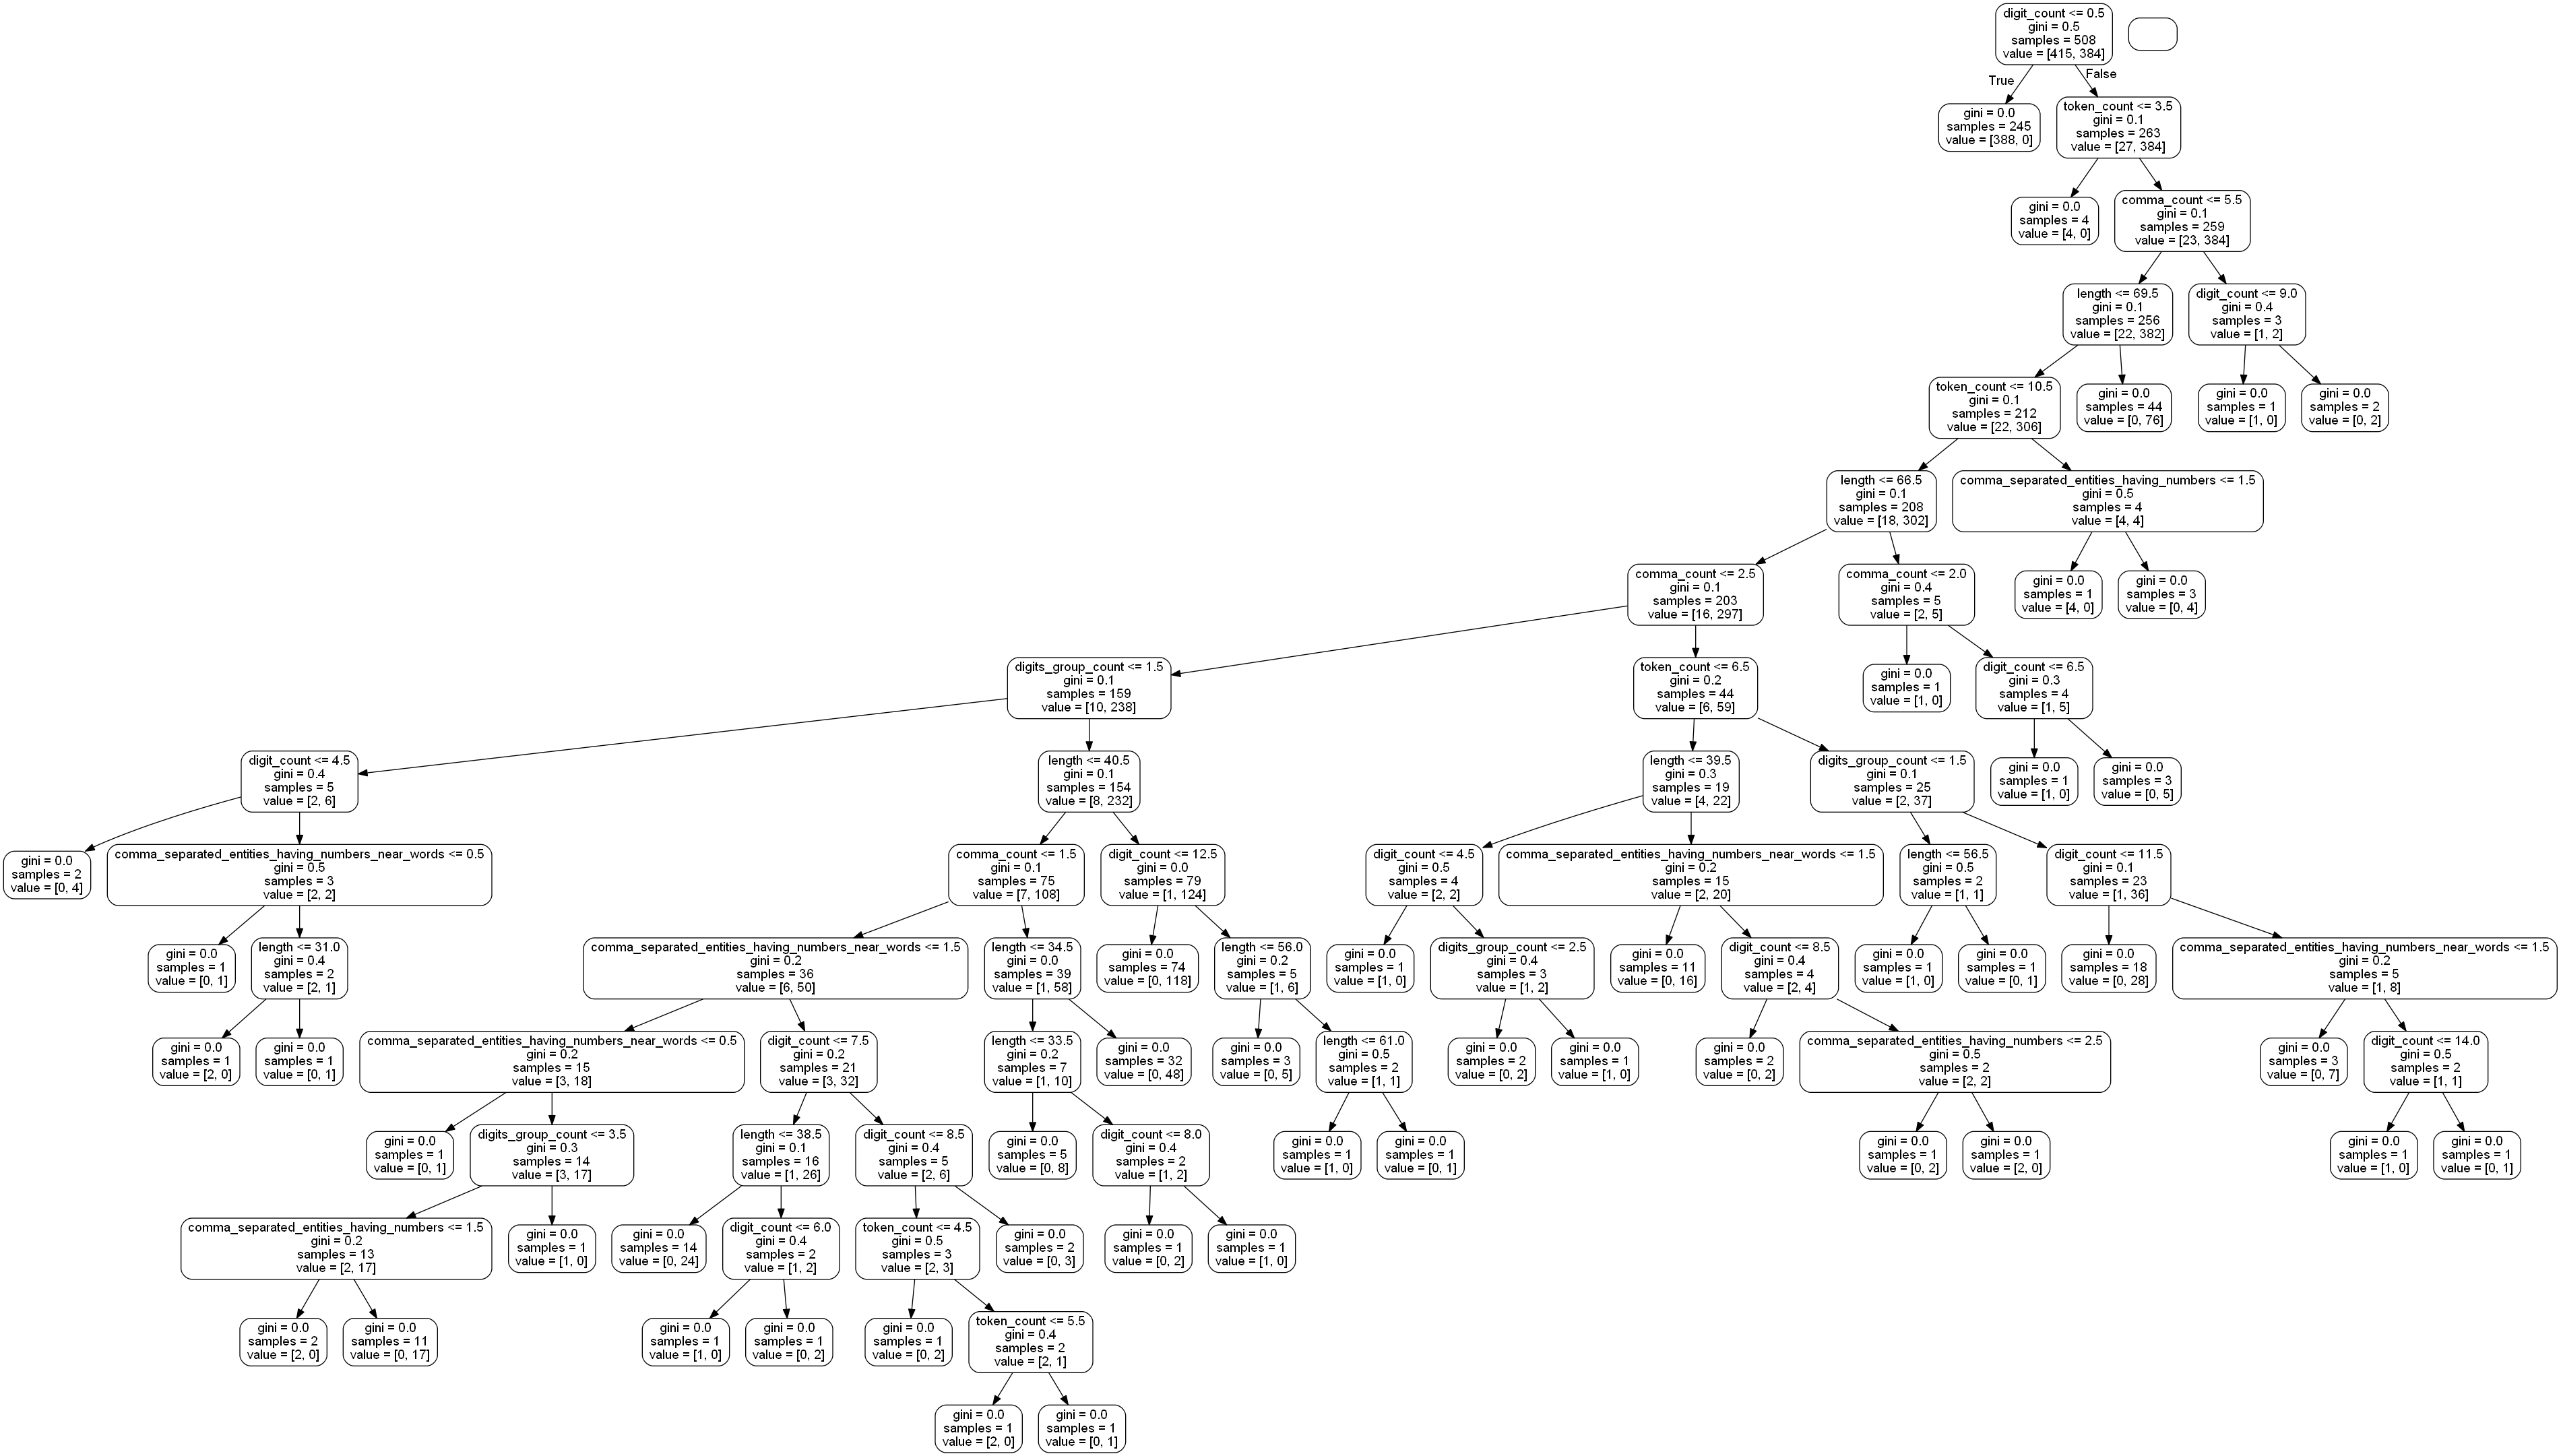

We can also analyse misclassified entries in greater detail:

In [ ]:
predictions = rf.predict(features)

dataFrame['predicted'] = predictions
write_DataFrame_to_excel(dataFrame, 'predicted.xlsx')

The was majority of classifications are correct, however, we can see that in some occasions Asian addresses are misclassified.
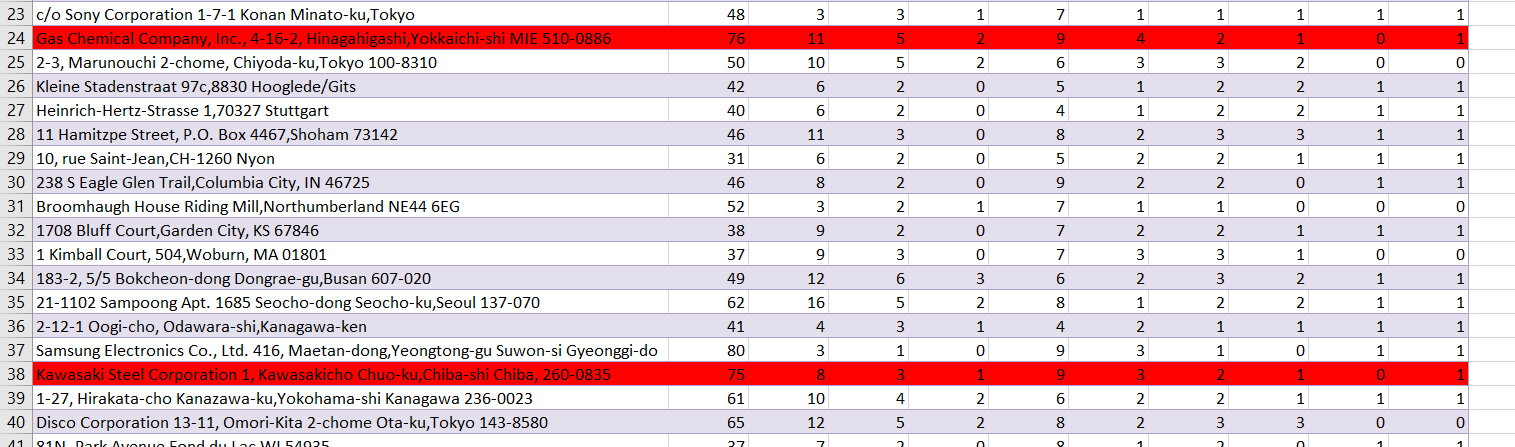

The model also classifies most mail-only addresses as complete, however, in the dataset there is no unanimous approach whether these addresses should be complete or incomplete:
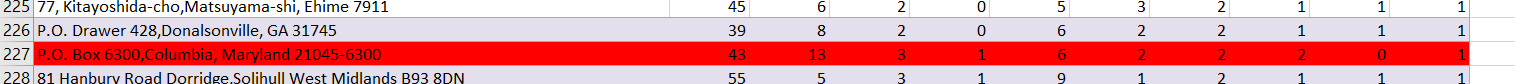

# Logistic Regression Model

Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem.

And for that reason, we are going to use this model to be compared with the others, to decide which is the best one to use for our problem of classifying addresses.

## Reading the dataset

we start by reading the excel file of the various addresses classified as complete or not, in order to use it to train our model.

In [35]:
import pandas as pd
from utils import read_DataFrame_from_file
from prepare import DATA_INPUT_FILENAME, NUMBER_OF_PARSABLE_RECORDS

raw_data = read_DataFrame_from_file(DATA_INPUT_FILENAME, NUMBER_OF_PARSABLE_RECORDS)
raw_data.head()

,person_id,person_name,person_address,cln1,cln2,cln3,person_ctry_code,cnt,chr_len,chr_len_label,...,street,nr,area,postal,city,region,country,unclear,status,label
0,3540,PURAC Biochem BV,"Arkelsedijk 46,4206 AC Gorinchem",Arkelsedijk 46 4206 AC Gorinchem,46 4206,46,NL,1,32,2,...,Arkelsedijk,46,,4206 AC,Gorinchem,,,,,1
1,28753,"Tinti, Maria Ornella",SIGMA-TAU Industrie Farmaceutiche Riunite S.p....,SIGMA-TAU Industrie Farmaceutiche Riunite S.p....,30 400 00040,30,IT,1,86,1,...,Via Pontina,km 30,,400 00040,Pomezia,,,,,1
2,35108,"Isobe, Shin-ichi, c/o Int. Prop. Dpt., NTT DoC...","Sanno Park Tower, 11-1, Nagatacho 2-chome,Chiy...",Sanno Park Tower 11-1 Nagatacho 2-chome Chiyod...,111 2,11-,JP,1,59,1,...,Nagatacho 2-chome 11-1,,Chiyoda-ku,,Tokyo,,,,,1
3,89830,"Hata, Yoshiki","c/o Hitachi Appliances, Inc. 390 Muramatsu, Sh...",c/o Hitachi Appliances Inc. 390 Muramatsu Shim...,390 4240926,390,JP,1,90,1,...,,,Shizuoka-ken,424-0926,"Shizuoka-shi, Shimizu-ku",Muramatsu,,,,0
4,94063,"Kim, Se-Jong","Legal & IP Team, Samsung SDI Co., Ltd., 428-5,...",Legal & IP Team Samsung SDI Co. Ltd. 428-5 Gon...,4285,428-,KR,1,92,1,...,428-5,,Gongse-ri; Kiheung-eup; Yongin-s,,Gyeonggi-do,,,,,1


## Data Pre-Processing
From the previously created prepare.py module with the various functions to process the data, we will process our table so that it only has numerical values so that our model is able to classify it.

In [36]:
from prepare import PROPERTY_ADDRESS, enrichDataFrameWithProperties, PROPERTY_LABEL

def processData(dataFrame: pd.DataFrame):
    
    processedData = pd.DataFrame()
    processedData[PROPERTY_ADDRESS] = dataFrame['person_address']
    enrichDataFrameWithProperties(processedData)
    processedData[PROPERTY_LABEL] = dataFrame['label']
    
    processedData.drop(PROPERTY_ADDRESS, axis=1, inplace=True)
    
    return processedData


addresses = processData(raw_data)
addresses.head()

,length,digit_count,digits_group_count,separated_digits_group_count,token_count,comma_count,comma_separated_entities_having_numbers,comma_separated_entities_having_numbers_near_words,label
0,32,6,2,0,5,1,2,1,1
1,86,10,3,1,12,4,2,0,1
2,59,4,3,1,8,4,2,1,1
3,90,10,3,1,10,4,2,2,0
4,92,4,2,1,13,7,1,0,1


### Checking for missing values
Just to make sure there are no missing values in our dataset, and in case if we have missing values trying to fill them in as an mean of the values for example, but in this case it won't be necessary.

In [37]:
addresses.isnull().sum()

length                                                0
digit_count                                           0
digits_group_count                                    0
separated_digits_group_count                          0
token_count                                           0
comma_count                                           0
comma_separated_entities_having_numbers               0
comma_separated_entities_having_numbers_near_words    0
label                                                 0
dtype: int64

## Generalized Data Analysis of the dataset
Let's do a little analysis of our dataset just to get an idea of how many columns and rows there are, what types our features are, and a little statistical analysis of them.

### 1. Number of rows and columns of train set
We can see that there are 999 rows and 9 columns

In [38]:
addresses.shape

(999, 9)

### 2. Dataset info
We can see all the features we have and that they are all of the integer type

In [39]:
addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   length                                              999 non-null    int64
 1   digit_count                                         999 non-null    int64
 2   digits_group_count                                  999 non-null    int64
 3   separated_digits_group_count                        999 non-null    int64
 4   token_count                                         999 non-null    int64
 5   comma_count                                         999 non-null    int64
 6   comma_separated_entities_having_numbers             999 non-null    int64
 7   comma_separated_entities_having_numbers_near_words  999 non-null    int64
 8   label                                               999 non-null    int64
dtypes: int64(9)
memory usa

### 3. Data Description
And we can see various statistical properties of each feature like the mean and the percentiles.

In [40]:
addresses.describe()

,length,digit_count,digits_group_count,separated_digits_group_count,token_count,comma_count,comma_separated_entities_having_numbers,comma_separated_entities_having_numbers_near_words,label
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,32.092092,3.982983,1.369369,0.255255,4.703704,1.328328,1.026026,0.660661,0.470470
std,26.633592,4.386022,1.556132,0.574953,3.758530,1.429123,1.087054,0.825425,0.499377
min,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,3.000000,1.000000,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000
75%,47.000000,7.000000,2.000000,0.000000,7.000000,2.000000,2.000000,1.000000,1.000000
max,164.000000,19.000000,6.000000,3.000000,20.000000,7.000000,6.000000,3.000000,1.000000


## Feature Selection of the addresses
Now that we've seen what all the features we have, we need to choose the best ones if necessary and eliminate the worst ones to avoid overfitting. And for that, let's start by using a correlation matrix.

### 1. Correlation Matrix with Heatmap
Correlation states how the features are related to each other.
Correlation can be positive (increase in one value of feature increases the value of the other variable) or negative (increase in one value of feature decreases the value of the other variable)
Heatmap makes it easy to identify which features are most related to each other, we will plot heatmap of correlated features using the seaborn library.
And in the matrix we can see how length and token_count have a very strong correlation, which makes sense because if the length of the addresses is large, the amount of tokens will obviously be higher.

<AxesSubplot:>

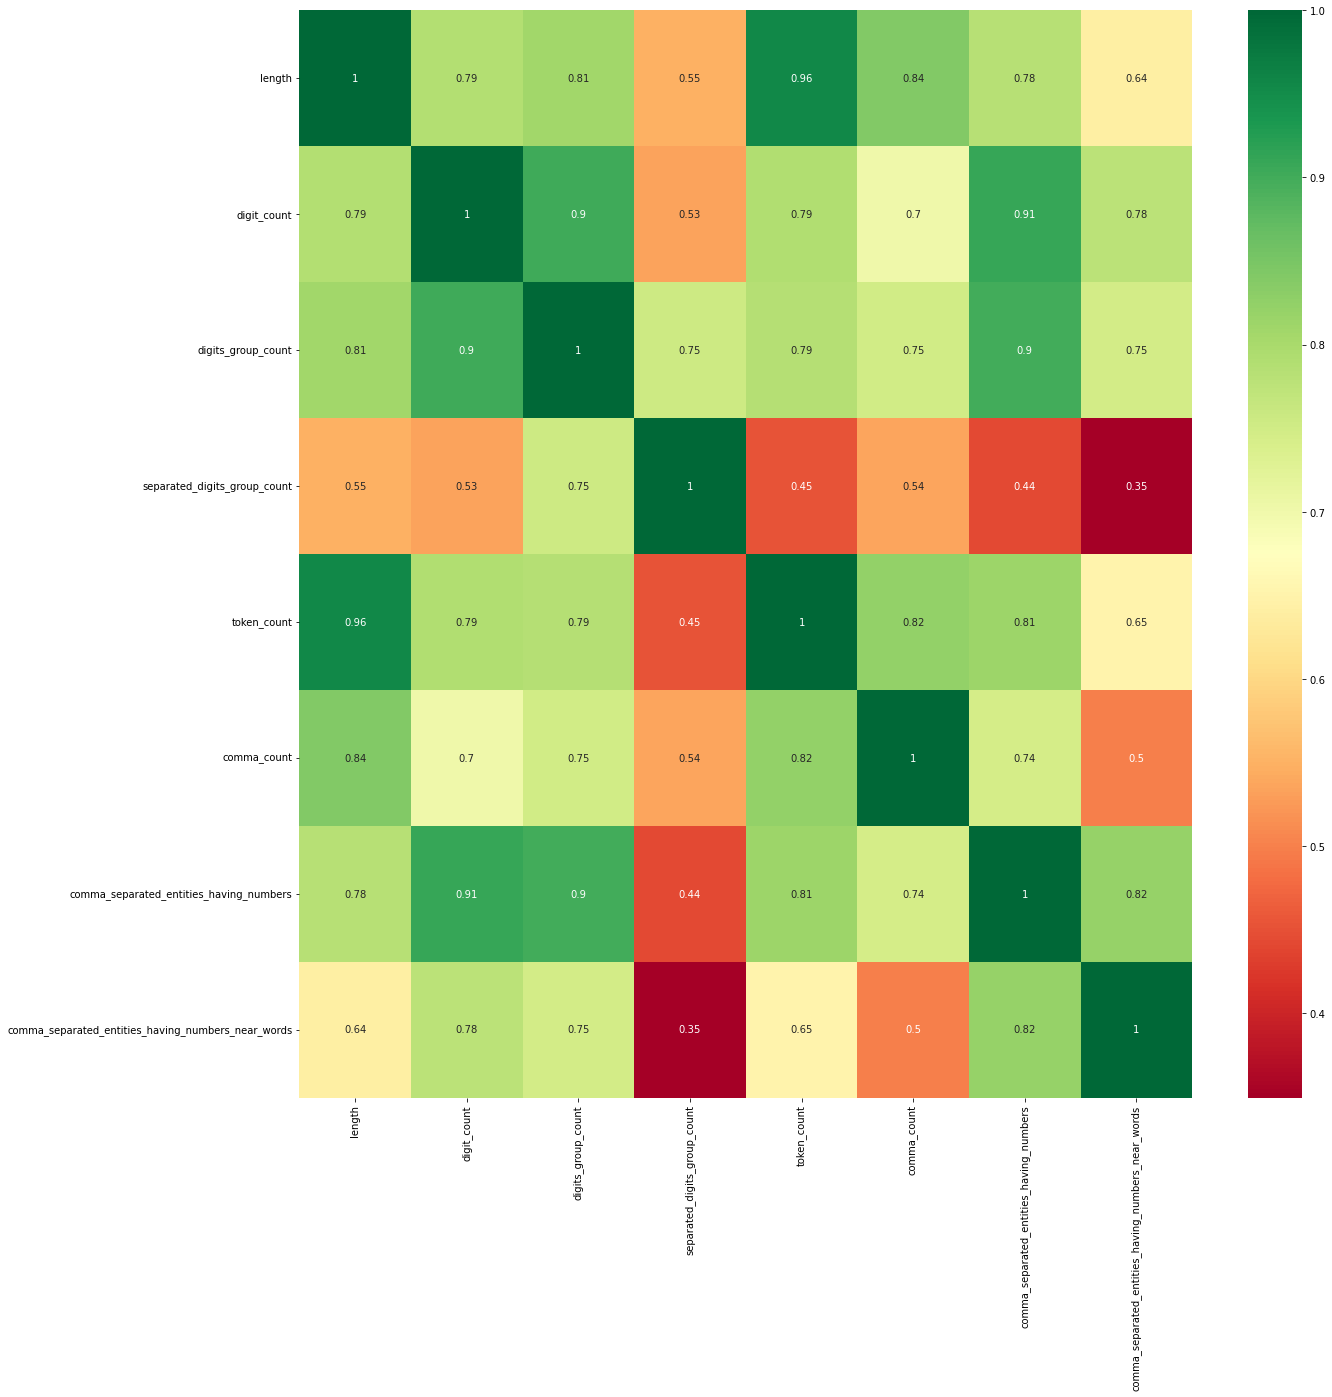

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

data = addresses.drop('label', axis=1)
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 2. Univariate Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.
The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the addresses Dataset.
And as we can see the two best features are length and number of digits. But as we also observed in the correlation matrix that length and token_count are strongly related and token_count being considered the third best feature, the choice of features to use in this model will be length, digit_count and token_count.

In [42]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = addresses.drop('label', axis=1)
X = data.iloc[:,0:20]  # independent columns
y = data.iloc[:,-1]    # target column i.e length

# apply SelectKBest class to extract top 7 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
featureScores.nlargest(7,'Score')  # print 7 best features

,Specs,Score
0,length,9935.521924
1,digit_count,3228.015716
4,token_count,1447.230852
2,digits_group_count,1084.668531
7,comma_separated_entities_having_numbers_near_w...,1029.218182
6,comma_separated_entities_having_numbers,853.300421
5,comma_count,451.254931


## Exploratory Data Analysis of each chosen feature
And to see how each feature is distributed and how they are related to each other, let's do a little analysis of each one.

### 1. Analysis of length feature

#### 1. Length distribution
The histogram below shows the distribution of string lengths that contain each address between 0 and 160 characters.
And we can see that it has a linear distribution with a negative slope where longer strings are less frequent than shorter strings. So as we can see small addresses between 0 and 20 exist in a large amount in the dataset.

<AxesSubplot:>

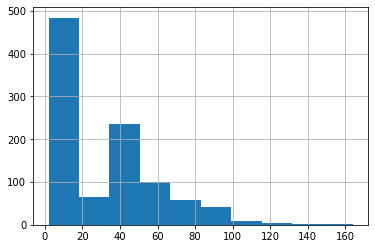

In [43]:
addresses.length.hist()

#### 2. Length group which is more likely to be completed
And interestingly, we can see that the longest strings have the highest probability of being complete, even if they are the ones that exist in the smallest amount, because we can see that the regression line shows a positive correlation.

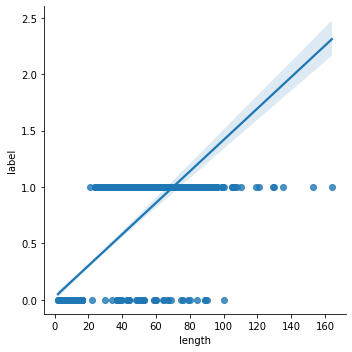

In [44]:
sns.lmplot(x='length',y='label',data=addresses)

### 2. Analysis of digit_count feature

#### 1. Count of addresses based of digit_count feature
The chart below shows the address count grouped by number of digits. We can see that most addresses do not even have digits, but addresses that have digits have a normal distribution, with an average around 8. That is, addresses with digits on average have around 8 digits.

0     481
7      91
6      73
9      62
8      55
10     53
5      46
11     30
3      25
4      25
12     17
13      9
2       9
16      7
1       4
15      4
14      4
17      3
19      1
Name: digit_count, dtype: int64

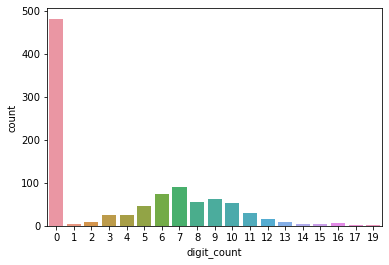

In [45]:
sns.countplot(x='digit_count', data=addresses)
addresses['digit_count'].value_counts()

#### 2. Percentage of addresses completed grouped by digit_count
The graph below shows the effect of the number of digits on the rate of the address being completed. The number of digits where it is 0, we can see that its probability of being complete is 0, the cause of this is that it usually has at least one digit in the addresses, either as part of the street or part of a zip code, for that if there is no digit, it is very likely that there is no street or postal code written, ie the address is likely to be incomplete.

,digit_count,label
0,0,0.000000
1,1,0.750000
2,2,0.666667
3,3,0.760000
4,4,0.920000
5,5,0.782609
6,6,0.931507
7,7,0.945055
8,8,0.945455
9,9,0.951613


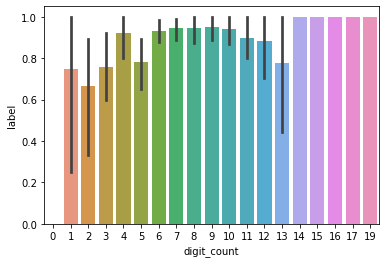

In [46]:
sns.barplot(x='digit_count',y='label',data=addresses)
addresses.groupby('digit_count',as_index=False).label.mean()

#### 3. Count of addresses completed based on digits_count
And obviously the chart below shows that among the addresses that are incomplete, most of them had no digit at all. But we can conlcude that having at least one digit increases drastically its probability of being a complete address. 

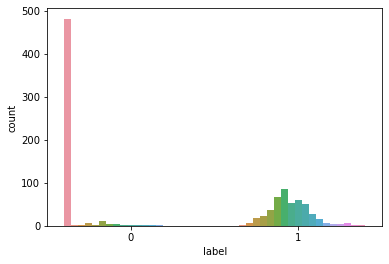

In [47]:
g = sns.countplot(x='label', hue='digit_count', data=addresses)
g.legend_.remove()

### 3. Analysis of token_count feature

#### 1. Count of addresses based of token_count feature
We can see in the chart below that the vast majority of addresses only have one or two tokens, quite possibly they are the addresses that only indicate the city, but we can also see, if we exclude addresses that only have two tokens or less, that they have a normal distribution with a possible average around 7 or 8, that is, on average the addresses have around 7 or 8 tokens.

1     288
2     155
6      92
7      79
8      78
5      57
4      50
9      43
3      43
11     35
10     27
12     19
13     13
14      6
15      4
18      3
16      3
17      2
19      1
20      1
Name: token_count, dtype: int64

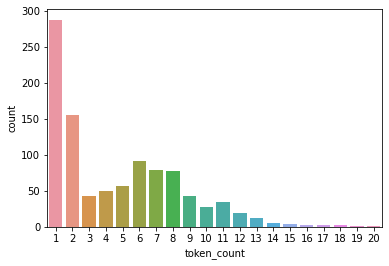

In [48]:
sns.countplot(x='token_count', data=addresses)
addresses['token_count'].value_counts()

#### 2. Percentage of addresses completed grouped by token_count
We can see in the chart below, that having 3 or less tokens the probability of the address being complete is practically zero, this is because with 3 or less tokens it is only possible for the address to be constituted only by the name of the city. But as long as you have at least 4 tokens the probability of being complete seems to be evenly distributed, around 90%, regardless of the number of tokens.

,token_count,label
0,1,0.000000
1,2,0.000000
2,3,0.023256
3,4,0.980000
4,5,0.929825
5,6,0.858696
6,7,0.911392
7,8,0.923077
8,9,0.906977
9,10,0.962963


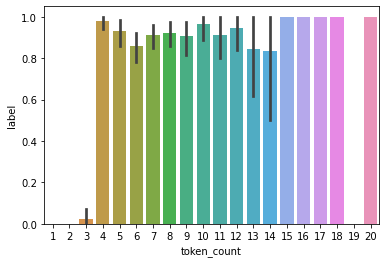

In [49]:
sns.barplot(x='token_count',y='label',data=addresses)
addresses.groupby('token_count',as_index=False).label.mean()

#### 3. Count of addresses completed based on token_count
And as it was deduced, addresses with 3 or less tokens are likely to be incomplete, as they must only contain the name of the city.

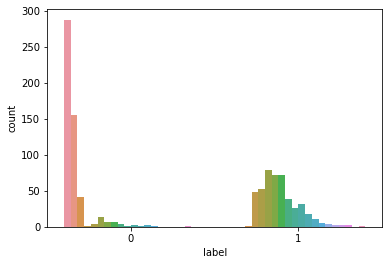

In [50]:
g = sns.countplot(x='label', hue='token_count', data=addresses)
g.legend_.remove()

### 4. Analysis of Label feature
In this case the label feature represents whether the address is complete or not.

#### 1. Count of the addresses completed
And we can see that a little more than half of the addresses are incomplete.

0    529
1    470
Name: label, dtype: int64

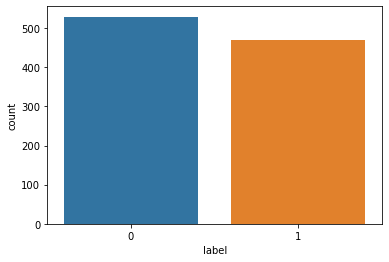

In [51]:
sns.countplot(x='label',data=addresses)
addresses['label'].value_counts()

## Model Building

### 1. Setting the values for independent (X) variable and dependent (Y) variable

In [52]:
from prepare import PROPERTY_LABEL, PROPERTY_SEPARATED_DIGIT_GROUP_COUNT, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS, PROPERTY_DIGITS_GROUP_COUNT, PROPERTY_COMMA_COUNT, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS

x = addresses.drop([PROPERTY_LABEL,  PROPERTY_SEPARATED_DIGIT_GROUP_COUNT, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS, PROPERTY_DIGITS_GROUP_COUNT, PROPERTY_COMMA_COUNT, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS], axis=1)
y = addresses.label

As previously chosen, we will use the length, digit_count and token_count features to train our model, excluding the other features.

In [53]:
x

,length,digit_count,token_count
0,32,6,5
1,86,10,12
2,59,4,8
3,90,10,10
4,92,4,13
...,...,...,...
994,84,8,11
995,86,16,11
996,106,6,15
997,99,9,14


And separate the column that indicates whether an address is complete or not into an dependent variable (y) and the rest into a independent variable (x).

In [54]:
y

0      1
1      1
2      1
3      0
4      1
      ..
994    1
995    1
996    1
997    1
998    1
Name: label, Length: 999, dtype: int64

### 2. Splitting the dataset

In [55]:
from sklearn.model_selection import train_test_split
from constants import RANDOM_STATE

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
RANDOM_STATE

42

We need to split our dataset into training and testing sets. We’ll perform this by importing train_test_split from the sklearn.model_selection library. And we will keep 20% of the data in our test dataset and the rest in our train dataset.

### 3. Implementing and fitting  the Logistic Regression Model

In [56]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

To build a logistic regression model, we need to create an instance of LogisticRegression() class and use x_train, y_train to train the model using the fit() method of that class.

### 4. Prediction on the test set

In [57]:
y_pred = lr_model.predict(x_test)

Predicted values:

In [58]:
y_pred

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0], dtype=int64)

Once we have fitted (trained) the model, we can make predictions using the predict() function. We pass the values of x_test to this method and compare the predicted values called y_pred with y_test values to check how accurate our predicted values are.

### 5. Actual value and the predicted value

In [59]:
a = pd.DataFrame({'Actual value': y_test, 'Predicted value':y_pred})
a.head()

,Actual value,Predicted value
453,0,0
793,1,1
209,0,1
309,0,0
740,0,0


## Evaluating the Model

### 1. Confusion matrix

Text(0.5, 257.44, 'Predicted label')

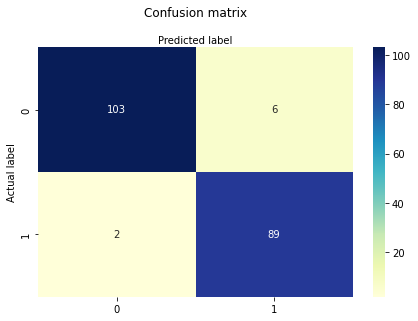

In [60]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

we will use a confusion matrix which is a table that is used to evaluate the performance of a classification model. The fundamental of a confusion matrix is the number of correct and incorrect predictions are summed up class-wise.

### 2. Classification report

Let's evaluate the model using model evaluation metrics such as accuracy, precision, recall and f1-score.

In [61]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.96
Precision: 0.9368421052631579
Recall: 0.978021978021978
f1-score: 0.956989247311828


Accuracy: Accuracy represents the number of correctly classified data instances over the total number of data instances. The accuracy obtained from the classification report is 0.96, which indicates that the accuracy of the model is 96%.

Precision: It is the number of correct positive results divided by the number of positive results predicted by the classifier. The precision obtained from the classification report is 0.94, which indicates that the precision of the model is 94%.

Recall: Recall gives a measure of how accurately our model can identify the relevant data. The recall value obtained from the classification report is 0.98, which indicates that the model can identify 98% of the relevant data.

f1-score: f1-Score is used to measure a test’s accuracy. The f1-score obtained from the classification report is 0.96, which indicates that the test accuracy is 96%.

### 3. ROC Curve

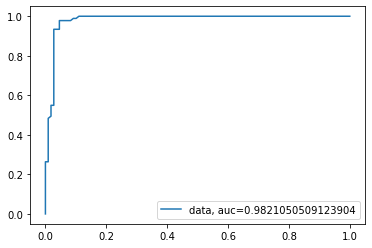

auc: 0.9821050509123904


In [62]:
y_pred_proba = lr_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print("auc:", auc)

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. Is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting between values of 0 and 1. 
which means our auc of 0.98 can be considered extremely good.

## Conclusion

There were 999 records in the dataset, out of which 80% of the data was given for training the model and 20% of the data, i.e., 200 records, were given for testing the model. And out of 200 records, 8 records were misclassified. which means that we can consider our model to be quite good at classifying our addresses as complete or not.

# Naive Bayes Model - Gaussian

In this model, the data needs to be in integers, meaning numbers. As we already have all the data in numbers, from extracting useful information such as number of tokens, letters, digts etc, that was no need for treating the data.

First we need to separate the features from the label. Features being the data that will be analized to train the model and the label, the classification.

In [63]:
import numpy as np
import pandas as pd

words_info = pd.DataFrame({
        'length': [25, 37, 59, 76, 38, 65, 59, 64, 44, 67],
        'digit_count': [7, 7, 11, 11, 9, 12, 12, 11, 8, 6],
        'digits_group_count': [2, 2, 3, 5, 2, 5, 5, 3, 2, 4],
        'token_count': [4, 6, 9, 9, 7, 8, 7, 9, 6, 9],
        'comma_count': [1, 1, 3, 4, 2, 2, 3, 4, 2, 3],
        'comma_entities_numbers': [2, 2, 3, 2, 2, 3, 3, 2, 2, 2],
        'comma_entities_numbers_words': [2, 2, 2, 1, 1, 3, 2, 1, 2, 2],
        'label': [1, 1, 1, 0, 1, 0, 0, 0, 1, 0]
    })

#print('Info:\n',words_info)
data = words_info.drop(['label'], axis=1)
label = np.array(words_info['label'])

print('\nData:\n',data)
print('\nLabel:\n',label)


Data:
    length  digit_count  digits_group_count  token_count  comma_count  \
0      25            7                   2            4            1   
1      37            7                   2            6            1   
2      59           11                   3            9            3   
3      76           11                   5            9            4   
4      38            9                   2            7            2   
5      65           12                   5            8            2   
6      59           12                   5            7            3   
7      64           11                   3            9            4   
8      44            8                   2            6            2   
9      67            6                   4            9            3   

   comma_entities_numbers  comma_entities_numbers_words  
0                       2                             2  
1                       2                             2  
2                       3

With that settled, now its time for preparing and grouping the data, so it can be anylized by the model. The information needs to be grouped in tuples, such as (x,y,z), so we used the function intertuples() to do it.

In [64]:
features = list(data.itertuples(index=False, name=None))
print('Features: ', features)

Features:  [(25, 7, 2, 4, 1, 2, 2), (37, 7, 2, 6, 1, 2, 2), (59, 11, 3, 9, 3, 3, 2), (76, 11, 5, 9, 4, 2, 1), (38, 9, 2, 7, 2, 2, 1), (65, 12, 5, 8, 2, 3, 3), (59, 12, 5, 7, 3, 3, 2), (64, 11, 3, 9, 4, 2, 1), (44, 8, 2, 6, 2, 2, 2), (67, 6, 4, 9, 3, 2, 2)]


Now that the data is already prepared to be used, it's possible to train the model, creating a Naive Bayes model classifier and predict values from given features.

In [65]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(features,label)

predicted1 = model.predict([[62,7,3,8,2,2,2]])
print('62,7,3,8,2,2,2 => ', predicted1)

predicted2 = model.predict([[62,3,3,8,2,2,2]])
print('62, ->3<- ,3,8,2,2,2 => ', predicted2)

predicted3 = model.predict([[62,3,3,4,2,2,2]])
print('62,3,3, ->4<- ,2,2,2 => ', predicted3)

62,7,3,8,2,2,2 =>  [1]
62, ->3<- ,3,8,2,2,2 =>  [0]
62,3,3, ->4<- ,2,2,2 =>  [1]


Seeing that the model works and responds to variations (remembering its a small set of data), we can now test how acurate the model is.

In [66]:
def get_precision_recall_f1(actual: list, predicted: list):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    wrong = 0

    for index, predictedVal in enumerate(predicted):
        actualVal = actual[index]
        if (actualVal and actualVal == predictedVal):
            true_positives += 1
        elif (predictedVal and actualVal != predictedVal):
            false_positives += 1
        elif (actualVal and actualVal != predictedVal):
            false_negatives += 1
    
    precision = true_positives / max(true_positives + false_positives, 1)
    recall = true_positives / max(true_positives + false_negatives, 1)
    f1 = 2 * ((precision * recall) / (1 if precision + recall == 0 else precision + recall))
        
    return [el * 100 for el in [precision, recall, f1]]

[precision, recall, f1] = get_precision_recall_f1([0,1,1,1,0], [1,1,0,0,0])

print('Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'.format(precision, recall, f1))

Precision: 50.00 | Recall: 33.33 | F1: 40.00


In [67]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=109)

train_predictions = model.predict(train_features)
train_accuracy = model.score(train_features, train_labels) * 100.0
[train_precision, train_recall, train_f1] = get_precision_recall_f1(train_labels, train_predictions)

test_predictions = model.predict(test_features)
test_accuracy = model.score(test_features, test_labels) * 100.0
[test_precision, test_recall, test_f1] = get_precision_recall_f1(test_labels, test_predictions)

print('For training data:')
print('Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'
      .format(train_accuracy, train_precision, train_recall, train_f1))
print('For test data:')
print('Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | F1: {:.2f}'
      .format(test_accuracy, test_precision, test_recall, test_f1))

For training data:
Accuracy: 100.00 | Precision: 100.00 | Recall: 100.00 | F1: 100.00
For test data:
Accuracy: 66.67 | Precision: 100.00 | Recall: 50.00 | F1: 66.67


# Compare AI algorithms and determine the most suitable one
Not going into much detail in this section, as we have already done something similar for each model, we will read the dataset, process it and classify it by each model and then see each classification report to find the best one.

## Reading the dataset

In [68]:
raw_data = read_DataFrame_from_file(DATA_INPUT_FILENAME, NUMBER_OF_PARSABLE_RECORDS)
raw_data.head()

,person_id,person_name,person_address,cln1,cln2,cln3,person_ctry_code,cnt,chr_len,chr_len_label,...,street,nr,area,postal,city,region,country,unclear,status,label
0,3540,PURAC Biochem BV,"Arkelsedijk 46,4206 AC Gorinchem",Arkelsedijk 46 4206 AC Gorinchem,46 4206,46,NL,1,32,2,...,Arkelsedijk,46,,4206 AC,Gorinchem,,,,,1
1,28753,"Tinti, Maria Ornella",SIGMA-TAU Industrie Farmaceutiche Riunite S.p....,SIGMA-TAU Industrie Farmaceutiche Riunite S.p....,30 400 00040,30,IT,1,86,1,...,Via Pontina,km 30,,400 00040,Pomezia,,,,,1
2,35108,"Isobe, Shin-ichi, c/o Int. Prop. Dpt., NTT DoC...","Sanno Park Tower, 11-1, Nagatacho 2-chome,Chiy...",Sanno Park Tower 11-1 Nagatacho 2-chome Chiyod...,111 2,11-,JP,1,59,1,...,Nagatacho 2-chome 11-1,,Chiyoda-ku,,Tokyo,,,,,1
3,89830,"Hata, Yoshiki","c/o Hitachi Appliances, Inc. 390 Muramatsu, Sh...",c/o Hitachi Appliances Inc. 390 Muramatsu Shim...,390 4240926,390,JP,1,90,1,...,,,Shizuoka-ken,424-0926,"Shizuoka-shi, Shimizu-ku",Muramatsu,,,,0
4,94063,"Kim, Se-Jong","Legal & IP Team, Samsung SDI Co., Ltd., 428-5,...",Legal & IP Team Samsung SDI Co. Ltd. 428-5 Gon...,4285,428-,KR,1,92,1,...,428-5,,Gongse-ri; Kiheung-eup; Yongin-s,,Gyeonggi-do,,,,,1


## Data Pre-Processing

In [69]:
addresses = processData(raw_data)
addresses.head()

,length,digit_count,digits_group_count,separated_digits_group_count,token_count,comma_count,comma_separated_entities_having_numbers,comma_separated_entities_having_numbers_near_words,label
0,32,6,2,0,5,1,2,1,1
1,86,10,3,1,12,4,2,0,1
2,59,4,3,1,8,4,2,1,1
3,90,10,3,1,10,4,2,2,0
4,92,4,2,1,13,7,1,0,1


## Random Forest Model

### 1. Setting the values for independent (X) variable and dependent (Y) variable

In [70]:
x = addresses.drop([PROPERTY_LABEL, PROPERTY_SEPARATED_DIGIT_GROUP_COUNT], axis=1)
y = addresses.label

### 2. Splitting the dataset

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

### 3. Implementing and fitting the Random Forest Model

In [72]:
rf_model = RandomForestClassifier(n_estimators = 1000, random_state = RANDOM_STATE)
rf_model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

### 4. Prediction on the test set

In [73]:
y_pred = rf_model.predict(x_test)

### 5. Classification report

In [74]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.955
Precision: 0.9183673469387755
Recall: 0.989010989010989
f1-score: 0.9523809523809524


## Logistic Regression Model

### 1. Setting the values for independent (X) variable and dependent (Y) variable

In [75]:
x = addresses.drop([PROPERTY_LABEL,  PROPERTY_SEPARATED_DIGIT_GROUP_COUNT, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS, PROPERTY_DIGITS_GROUP_COUNT, PROPERTY_COMMA_COUNT, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS], axis=1)
y = addresses.label

### 2. Splitting the dataset

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

### 3. Implementing and fitting the Logistic Regression Model

In [77]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

### 4. Prediction on the test set

In [78]:
y_pred = lr_model.predict(x_test)

### 5. Classification report

In [79]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.96
Precision: 0.9368421052631579
Recall: 0.978021978021978
f1-score: 0.956989247311828


## Naive Bayes Model

### 1. Setting the values for independent (X) variable and dependent (Y) variable

In [80]:
x = addresses.drop([PROPERTY_LABEL, PROPERTY_SEPARATED_DIGIT_GROUP_COUNT], axis=1)
y = addresses.label

### 2. Splitting the dataset

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

### 3. Implementing and fitting the Logistic Regression Model

In [82]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

GaussianNB()

### 4. Prediction on the test set

In [83]:
y_pred = nb_model.predict(x_test)

### 5. Classification report

In [84]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.955
Precision: 0.91
Recall: 1.0
f1-score: 0.9528795811518325


## Choosing the most suitable AI algorithm of the three

In fact, we can conclude that any of the 3 models are extremely well suited to sorting addresses. So, as we can see in the classification report of each one, regardless of the choice, we will have a very good classification of the addresses and the final result would not change significantly.. But since we can only use one, let's compare and choose one through f1-score, since f1-score is normally used as a measure to evaluate binary classification models, where it conveys the balance between the precision and the recall. 
And of the 3 models f1-score:
- 1º Logisitic regression: 0.956989247311828
- 2º Naive Bayes: 0.9528795811518325
- 3º Random Forest: 0.9523809523809524

And as we can see the choice of the model for a very small difference will be the logistic regression model.